## Bean Billiard

In [15]:
import os
import sys
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# sys.path.append("..")
from prepare_data import *
from boundary import *
from GFNN import GFNN

### Prepare Data

In [16]:
# TODO - randomly initialize r0, theta
# (theta from 0 to pi or 0 to pi/2 to ensure cos is positive) and (r in some small region from [0,1] in each axis)
# Parameters for root finding
custom_rf = {'tol': 2E-12, 'maxiter': 50,
            'rootfind_open': rf.newton,
            'rootfind_bracketing': rf.bisect,
            'param_rootfind': 'bracketing'}

# Define boundary for bean billiard system
a = 0.16
b = 0.1
c = 2.0
d = 2.0

In [17]:
bdy = BeanBoundary(a,b,c,d, **custom_rf)

def plot_bean(bdy, seq_len, r0, theta):
    """Create side-by-side plots of trajectories with the same i.c.'s
        but different boundarys."""
    plt.title(r'Trajectories for $r_0$={0}, $\theta_0$={1}'
                 .format(r0, theta))
    v0 = np.array([np.cos(theta), np.sin(theta)])
    bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
    plt.plot(bdyline[0], bdyline[1])
    traj_line, = plt.plot([0, 0], [0, 0], 'o-')
    # Initialize plotline data
    state = init_state(r0, v0, bdy)
    missing = seq_len - state['trajectory'].shape[1]
    if missing > 0:
        propagate(state, missing)
        traj_line.set_xdata(state['trajectory'][0])
        traj_line.set_ydata(state['trajectory'][1])
    plt.title(str(bdy))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    plt.ylim([-1, 1])

# plot_bean(bdy, 50, np.array([1,0.2]), 0.1)

In [18]:
# Generate dataset using the boundary defined above
CURRENT_DIR = str(pathlib.Path(".").parent.absolute())
prefix = "chaotic_"
train_file_path, test_file_path = PrepareData(CURRENT_DIR + "/data",
                                              a = a,
                                              b = b,
                                              c = c,
                                              d = d,
                                              n_train=10000,
                                              n_test=100,
                                              seq_len=2,
                                              prefix=prefix,
                                              **custom_rf)

Training data already exists!
Testing data already exists!


In [19]:
import torch
data = torch.load(test_file_path)
data.seqs[1].shape

(2, 4)

### Initialize (load) the model

In [20]:
h = 0.5
parameters = {
    "dim": 2,
    "step_size": h,
    "train_file_path": train_file_path,
    "test_file_path": test_file_path,
    "batch_size": 200,
    "n_neurons": [4, 200, 100, 50, 20, 1],
    "lr": 1e-3,
}
# 
nn = GFNN(parameters)
# If saved checkpoint of GFNN exists, load GFNN from the checkpoint.
# Uncomment the following two lines if a loaded GFNN is deseired.
# if os.path.exists(STORAGE_DIR + "/checkpoint.pt"):
#     nn.Load(STORAGE_DIR)

### Train

In [21]:
# Train.
epochs = 20
nn.Train(epochs)

# Serialize the trained model.
STORAGE_DIR = CURRENT_DIR + "/" + prefix + f"({a},{b},{c},{d})" + "/"
if not os.path.exists(STORAGE_DIR):
    os.mkdir(STORAGE_DIR)
nn.Save(STORAGE_DIR)

Epoch 20: training loss=1.27e-01, testing loss=1.18e-01: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


Text(0, 0.5, 'Training loss')

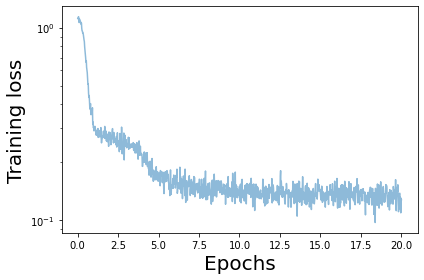

In [22]:
fig, ax = plt.subplots(tight_layout=True)
ax.semilogy((np.arange(len(nn.loss_array))+1)/(nn.n_train/nn.args["batch_size"]), nn.loss_array, alpha=0.5)
ax.set_xlabel("Epochs", fontsize=20)
ax.set_ylabel("Training loss", fontsize=20)

### Predict

In [23]:
def EvolveFlow(nn, r, v, n):
    """
    Evolve the flow by the trained GFNN.
    Args:
        nn: the neural network
        r, v: the initial condition
        n: the steps to evolve
    """
    rspan = [r]
    vspan = [v]
    for i in tqdm(range(n)):
        r, v = nn.Predict(r, v)
        # p = np.fmod(p+2*np.pi, 2*np.pi)
        # t = np.fmod(t+2*np.pi, 2*np.pi)
        rspan.append(r)
        vspan.append(v)
    return np.array(rspan), np.array(vspan)

def EvolveBilliard(bdy, r0, theta, seq_len, a, b, c, d):
    """
    Evolve the exact maps.
    Args:
        q, t: the initial condition.
        n: the steps to evolve.
        K: parameters in standard map.
    """
    # Generate seq_len steps of the billiard trajectory
    bdy = BeanBoundary(a,b,c,d, **custom_rf)
    v0 = np.array([np.cos(theta), np.sin(theta)])
    state = init_state(r0, v0, bdy)
    missing = seq_len - state['trajectory'].shape[1]
    if missing > 0:
        propagate(state, missing)
    seq = state['trajectory'].T
    return seq    
    # pspan = [p]
    # tspan = [t]
    # for i in tqdm(range(n)):
    #     p, t = StandardMap(p, t, K)
    #     p = np.fmod(p+2*np.pi, 2*np.pi)
    #     t = np.fmod(t+2*np.pi, 2*np.pi)
    #     pspan.append(p)
    #     tspan.append(t)
    # return np.array(pspan), np.array(tspan)



#### Evolve the flow

In [24]:
# Initial condition for prediction
steps = 10000

p, t = np.array([0.6,0.4]), np.array([np.cos(0.1), np.sin(0.1)])
# pspan_exact, tspan_exact = EvolveExactMap(p, t, steps, K)
pspan_nn, tspan_nn = EvolveFlow(nn, p, t, steps)


100%|██████████| 10000/10000 [00:31<00:00, 314.03it/s]


#### Plot

NameError: name 'tspan_exact' is not defined

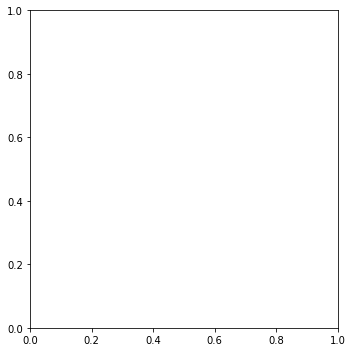

In [25]:
fig = plt.figure(tight_layout=True, figsize=(5, 5))
gs = gridspec.GridSpec(1, 1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(tspan_exact, pspan_exact, '.', label='True')
ax.plot(tspan_nn, pspan_nn, '.', label='GFNN', alpha=0.5)
ax.set_xlabel(r"$\theta$", fontsize=20)
ax.set_ylabel(r"$p$", fontsize=20)
ax.set_xlim([0,2*np.pi])
ax.set_ylim([0,2*np.pi])
ax.set_title("Trajectory: epoch=" + str(nn.epoch), fontsize=20)
ax.legend(fontsize=20)

NameError: name 'r0' is not defined

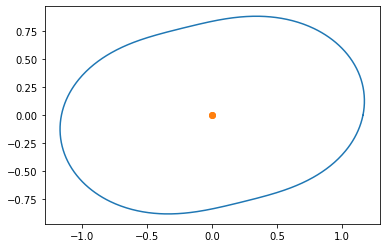

In [26]:
bdy = BeanBoundary(a,b,c,d, **custom_rf)
seq_len = steps
bdyline = bdy.coords_cart(np.arange(0, 2*np.pi, 0.01))
plt.plot(bdyline[0], bdyline[1])
plt.plot(pspan_nn[:,0], pspan_nn[:,1], 'o-')
# Initialize plotline data
state = init_state(r0, v0, bdy)
missing = seq_len - state['trajectory'].shape[1]
if missing > 0:
    propagate(state, missing)
    traj_line.set_xdata(state['trajectory'][0])
    traj_line.set_ydata(state['trajectory'][1])
plt.title(str(bdy))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.ylim([-1, 1])